<a href="https://colab.research.google.com/github/rolandoteniya/nlp-pos-tagging-bilstm-transformer/blob/main/POS_Tagging_NLP_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# University of Liverpool

## COMP634 - Applied AI

## Assignment 3

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import math
import numpy as np
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 1. **Data Management**

In this section, we:
1. Load and preprocess the POS tagging dataset
2. Create vocabulary mappings for words and tags
3. Define our experimental protocol (80-10-10 train/val/test split)
4. Create custom Dataset and DataLoader classes

In [ ]:
# Load POS dataset where each line contains word-tag and sentences are separated by blank lines.
def load_pos_data(filepath):
    sentences = []
    tags_list = []

    current_sentence = []
    current_tags = []

    # Loads word-tag pairs from the file and collects them into sentence-aligned lists using empty lines as delimiters.
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line == '':
                if current_sentence:
                    sentences.append(current_sentence)
                    tags_list.append(current_tags)
                    current_sentence = []
                    current_tags = []
            else:
                parts = line.split(' ')
                if len(parts) == 2:
                    word, tag = parts
                    current_sentence.append(word.lower())
                    current_tags.append(tag)

    if current_sentence:
        sentences.append(current_sentence)
        tags_list.append(current_tags)

    return sentences, tags_list

# Load the data
filepath = '/content/drive/MyDrive/COMP 634/Applied AI Assignments/Assignment 3/assignment3-pos-dataset.txt'
sentences, tags_list = load_pos_data(filepath)

In [ ]:
# Class to handle word/tag to index mappings.
class Vocabulary:
    def __init__(self, min_freq=1):
        # <PAD> token for padding and <UNK> token for unknown words
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = Counter()
        self.min_freq = min_freq
        self.n_words = 2

    def add_sentence(self, sentence):
        for word in sentence:
            self.word_freq[word] += 1

    def build_vocab(self):
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = self.n_words
                self.idx2word[self.n_words] = word
                self.n_words += 1

    def __len__(self):
        return self.n_words

# Separate vocabulary for POS tags.
class TagVocabulary:
    def __init__(self):
        self.tag2idx = {'<PAD>': 0}
        self.idx2tag = {0: '<PAD>'}
        self.n_tags = 1

    def add_tags(self, tags):
        for tag in tags:
            if tag not in self.tag2idx:
                self.tag2idx[tag] = self.n_tags
                self.idx2tag[self.n_tags] = tag
                self.n_tags += 1

    def __len__(self):
        return self.n_tags

# Build vocabularies
word_vocab = Vocabulary(min_freq=1)
tag_vocab = TagVocabulary()

for sentence in sentences:
    word_vocab.add_sentence(sentence)
word_vocab.build_vocab()

for tags in tags_list:
    tag_vocab.add_tags(tags)

In [ ]:
# 80/10/10 split for train/val/test at sentence level

# First split: 80% train and 20% temp (for val and test)
train_sentences, temp_sentences, train_tags, temp_tags = train_test_split(
    sentences, tags_list, test_size=0.2, random_state=42
)

# Second split: 50% of temp (10% val) and 50% of temp (10% test)
val_sentences, test_sentences, val_tags, test_tags = train_test_split(
    temp_sentences, temp_tags, test_size=0.5, random_state=42
)

print(f"Training set: {len(train_sentences)} sentences")
print(f"Validation set: {len(val_sentences)} sentences")
print(f"Test set: {len(test_sentences)} sentences")

Training set: 3131 sentences
Validation set: 391 sentences
Test set: 392 sentences


In [ ]:
# Dataset class for POS tagging
class POSDataset(Dataset):
    def __init__(self, sentences, tags_list, word_vocab, tag_vocab):
        self.sentences = sentences
        self.tags_list = tags_list
        self.word_vocab = word_vocab
        self.tag_vocab = tag_vocab

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags_list[idx]

        # Convert words to indices
        word_indices = [self.word_vocab.word2idx.get(word, self.word_vocab.word2idx['<UNK>']) for word in sentence]

        # Convert tags to indices
        tag_indices = [self.tag_vocab.tag2idx[tag] for tag in tags]

        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(tag_indices, dtype=torch.long)

# Collate function to pad sequences to the same length within a batch
def collate_fn(batch):
    sentences, tags = zip(*batch)

    # Get lengths for masking
    lengths = torch.tensor([len(s) for s in sentences])

    # Pad sequences
    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=0)
    padded_tags = pad_sequence(tags, batch_first=True, padding_value=0)

    return padded_sentences, padded_tags, lengths

# Create datasets
train_dataset = POSDataset(train_sentences, train_tags, word_vocab, tag_vocab)
val_dataset = POSDataset(val_sentences, val_tags, word_vocab, tag_vocab)
test_dataset = POSDataset(test_sentences, test_tags, word_vocab, tag_vocab)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 98
Number of validation batches: 13
Number of test batches: 13


---

# 2. **Neural Networks**

In this section, we:
1. Create an LSTM-based RNN for sequence tagging
2. Create a Transformer-based model for sequence tagging
3. Define loss functions and optimizers
4. Train both models and plot training curves

In [ ]:
# Model 1 - Bidirectional LSTM for POS Tagging
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=128, num_layers=2, dropout=0.3, pad_idx=0):
        super(BiLSTMTagger, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)

        # Pack sequences for efficiency
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
            lstm_out, _ = self.lstm(packed)
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        else:
            lstm_out, _ = self.lstm(embedded)

        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)

        return logits

In [ ]:
# Model 2 - Transformer-based model for POS Tagging
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]

        return self.dropout(x)

# Transformer Encoder model for sequence labeling
class TransformerTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1, pad_idx=0):
        super(TransformerTagger, self).__init__()

        self.d_model = d_model
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, tagset_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths=None):
        # Create padding mask
        padding_mask = (x == self.pad_idx)

        # Embedding and positional encoding
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        embedded = self.pos_encoder(embedded)

        # Transformer encoder
        transformer_out = self.transformer_encoder(
            embedded,
            src_key_padding_mask=padding_mask
        )

        transformer_out = self.dropout(transformer_out)
        logits = self.fc(transformer_out)

        return logits

In [ ]:
# Training helper function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    for sentences, tags, lengths in dataloader:
        sentences = sentences.to(device)
        tags = tags.to(device)

        optimizer.zero_grad()

        # Forward pass
        logits = model(sentences, lengths)

        # Reshape for loss computation
        logits_flat = logits.view(-1, logits.shape[-1])
        tags_flat = tags.view(-1)

        # Compute loss ignoring padding tokens
        loss = criterion(logits_flat, tags_flat)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy excluding padding
        predictions = logits.argmax(dim=-1)
        mask = tags != 0
        total_correct += ((predictions == tags) & mask).sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = (total_correct / total_tokens) if total_tokens > 0 else 0

    return avg_loss, accuracy

# Evaluation helper function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    with torch.no_grad():
        for sentences, tags, lengths in dataloader:
            sentences = sentences.to(device)
            tags = tags.to(device)

            logits = model(sentences, lengths)

            logits_flat = logits.view(-1, logits.shape[-1])
            tags_flat = tags.view(-1)

            loss = criterion(logits_flat, tags_flat)
            total_loss += loss.item()

            predictions = logits.argmax(dim=-1)
            mask = tags != 0
            total_correct += ((predictions == tags) & mask).sum().item()
            total_tokens += mask.sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0

    return avg_loss, accuracy

In [ ]:
# Training function with plotting
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device, model_name):
    model = model.to(device)

    # CrossEntropyLoss with ignore_index for padding
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Adam with weight decay
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = 0
    best_model_state = None

    print(f"Training {model_name}:")

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load best model state
    model.load_state_dict(best_model_state)

    return model, train_losses, train_accs, val_losses, val_accs, best_val_acc

In [ ]:
# Training hyperparameters
num_epochs = 30
learning_rate = 0.001
embedding_dim = 128
hidden_dim = 128

# Initialize BiLSTM model
bilstm_model = BiLSTMTagger(
    vocab_size=len(word_vocab),
    tagset_size=len(tag_vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=2,
    dropout=0.3,
    pad_idx=0
)

# Train BiLSTM
bilstm_model, lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs, lstm_best_acc = train_model(
    bilstm_model, train_loader, val_loader, num_epochs, learning_rate, device, "BiLSTM Tagger"
)

print(f"\nBest BiLSTM Validation Accuracy: {lstm_best_acc:.4f}")

Training BiLSTM Tagger:
Epoch [1/30] - Train Loss: 2.2599, Train Acc: 0.3719 | Val Loss: 1.4244, Val Acc: 0.5804
Epoch [5/30] - Train Loss: 0.6499, Train Acc: 0.8017 | Val Loss: 0.5797, Val Acc: 0.8220
Epoch [10/30] - Train Loss: 0.3551, Train Acc: 0.8888 | Val Loss: 0.4127, Val Acc: 0.8754
Epoch [15/30] - Train Loss: 0.2109, Train Acc: 0.9337 | Val Loss: 0.3626, Val Acc: 0.8982
Epoch [20/30] - Train Loss: 0.1358, Train Acc: 0.9573 | Val Loss: 0.3422, Val Acc: 0.9094
Epoch [25/30] - Train Loss: 0.0905, Train Acc: 0.9719 | Val Loss: 0.3409, Val Acc: 0.9150
Epoch [30/30] - Train Loss: 0.0637, Train Acc: 0.9804 | Val Loss: 0.3426, Val Acc: 0.9183

Best BiLSTM Validation Accuracy: 0.9183


In [ ]:
# Initialize Transformer model
transformer_model = TransformerTagger(
    vocab_size=len(word_vocab),
    tagset_size=len(tag_vocab),
    d_model=embedding_dim,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    pad_idx=0
)

# Train Transformer
transformer_model, trans_train_losses, trans_train_accs, trans_val_losses, trans_val_accs, trans_best_acc = train_model(
    transformer_model, train_loader, val_loader, num_epochs, learning_rate, device, "Transformer Tagger"
)

print(f"\nBest Transformer Validation Accuracy: {trans_best_acc:.4f}")

Training Transformer Tagger:
Epoch [1/30] - Train Loss: 1.8543, Train Acc: 0.4642 | Val Loss: 1.3111, Val Acc: 0.5972
Epoch [5/30] - Train Loss: 0.7414, Train Acc: 0.7735 | Val Loss: 0.6941, Val Acc: 0.7942
Epoch [10/30] - Train Loss: 0.4331, Train Acc: 0.8646 | Val Loss: 0.5427, Val Acc: 0.8442
Epoch [15/30] - Train Loss: 0.2907, Train Acc: 0.9035 | Val Loss: 0.5437, Val Acc: 0.8561
Epoch [20/30] - Train Loss: 0.1919, Train Acc: 0.9346 | Val Loss: 0.5675, Val Acc: 0.8660
Epoch [25/30] - Train Loss: 0.1463, Train Acc: 0.9494 | Val Loss: 0.5971, Val Acc: 0.8673
Epoch [30/30] - Train Loss: 0.1336, Train Acc: 0.9546 | Val Loss: 0.6104, Val Acc: 0.8685

Best Transformer Validation Accuracy: 0.8690


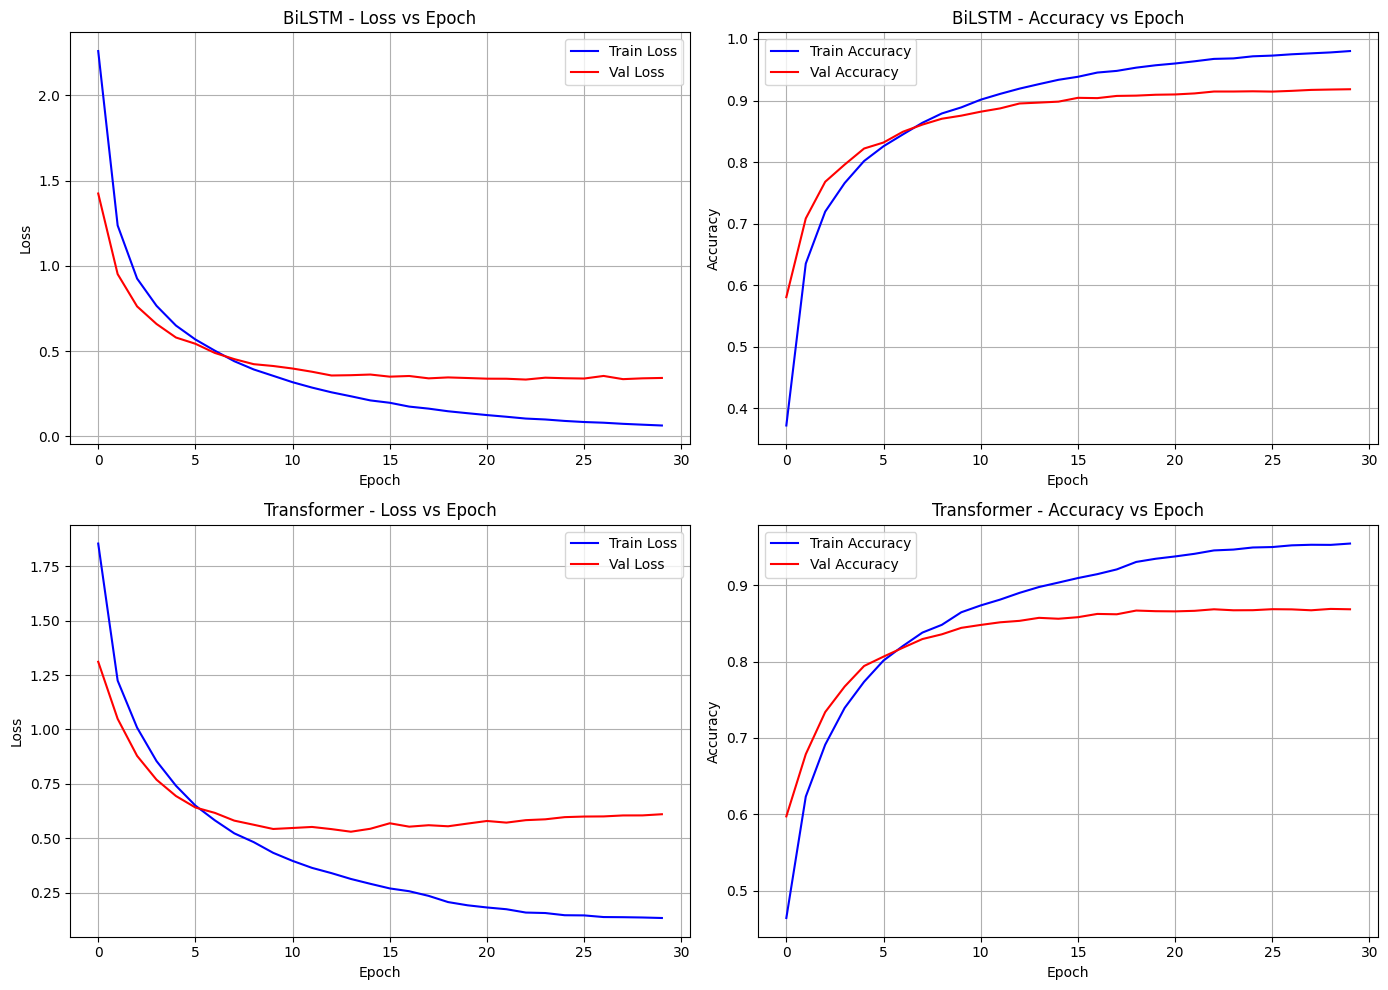

In [ ]:
# Plot training curves for both models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# BiLSTM Loss
axes[0, 0].plot(lstm_train_losses, label='Train Loss', color='blue')
axes[0, 0].plot(lstm_val_losses, label='Val Loss', color='red')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('BiLSTM - Loss vs Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True)

# BiLSTM Accuracy
axes[0, 1].plot(lstm_train_accs, label='Train Accuracy', color='blue')
axes[0, 1].plot(lstm_val_accs, label='Val Accuracy', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('BiLSTM - Accuracy vs Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Transformer Loss
axes[1, 0].plot(trans_train_losses, label='Train Loss', color='blue')
axes[1, 0].plot(trans_val_losses, label='Val Loss', color='red')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Transformer - Loss vs Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Transformer Accuracy
axes[1, 1].plot(trans_train_accs, label='Train Accuracy', color='blue')
axes[1, 1].plot(trans_val_accs, label='Val Accuracy', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Transformer - Accuracy vs Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Determine best model
if lstm_best_acc > trans_best_acc:
    best_model = bilstm_model
    best_model_name = "BiLSTM"
    print(f"\nBest Model: BiLSTM (Accuracy: {lstm_best_acc:.4f})")
else:
    best_model = transformer_model
    best_model_name = "Transformer"
    print(f"\nBest Model: Transformer (Accuracy: {trans_best_acc:.4f})")


Best Model: BiLSTM (Accuracy: 0.9183)


---

# 3. **Evaluate Models**

In this section, we evaluate the best model on the test set using multiple metrics:
1. Overall Accuracy
2. Macro F1-Score
3. Weighted Precision, Recall, and F1-Score
4. Confusion Matrix visualization

In [ ]:
# Get all predictions and ground truth labels from a dataloader
def get_predictions(model, dataloader, device, tag_vocab):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sentences, tags, lengths in dataloader:
            sentences = sentences.to(device)
            tags = tags.to(device)

            logits = model(sentences, lengths)
            predictions = logits.argmax(dim=-1)

            # Flatten and exclude padding
            for pred_seq, tag_seq in zip(predictions, tags):
                for pred, tag in zip(pred_seq, tag_seq):
                    if tag.item() != 0:
                        all_predictions.append(pred.item())
                        all_labels.append(tag.item())

    return all_predictions, all_labels

# Get predictions on test set using the best model
test_predictions, test_labels = get_predictions(best_model, test_loader, device, tag_vocab)

In [ ]:
# Metric 1: Overall Accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Metric 2: Macro F1-Score
macro_f1 = f1_score(test_labels, test_predictions, average='macro', zero_division=0)

# Metric 3: Weighted Precision class imbalance
weighted_precision = precision_score(test_labels, test_predictions, average='weighted', zero_division=0)

# Additional metrics for comprehensive evaluation
weighted_recall = recall_score(test_labels, test_predictions, average='weighted', zero_division=0)
weighted_f1 = f1_score(test_labels, test_predictions, average='weighted', zero_division=0)

print(f"Test set evaluation results - {best_model_name}:")
print(f"{'Overall Accuracy':<30} {test_accuracy:.4f}")
print(f"{'Macro F1-Score':<30} {macro_f1:.4f}")
print(f"{'Weighted Precision':<30} {weighted_precision:.4f}")
print(f"{'Weighted Recall':<30} {weighted_recall:.4f}")
print(f"{'Weighted F1-Score':<30} {weighted_f1:.4f}")

Test set evaluation results - BiLSTM:
Overall Accuracy               0.9163
Macro F1-Score                 0.8576
Weighted Precision             0.9183
Weighted Recall                0.9163
Weighted F1-Score              0.9166


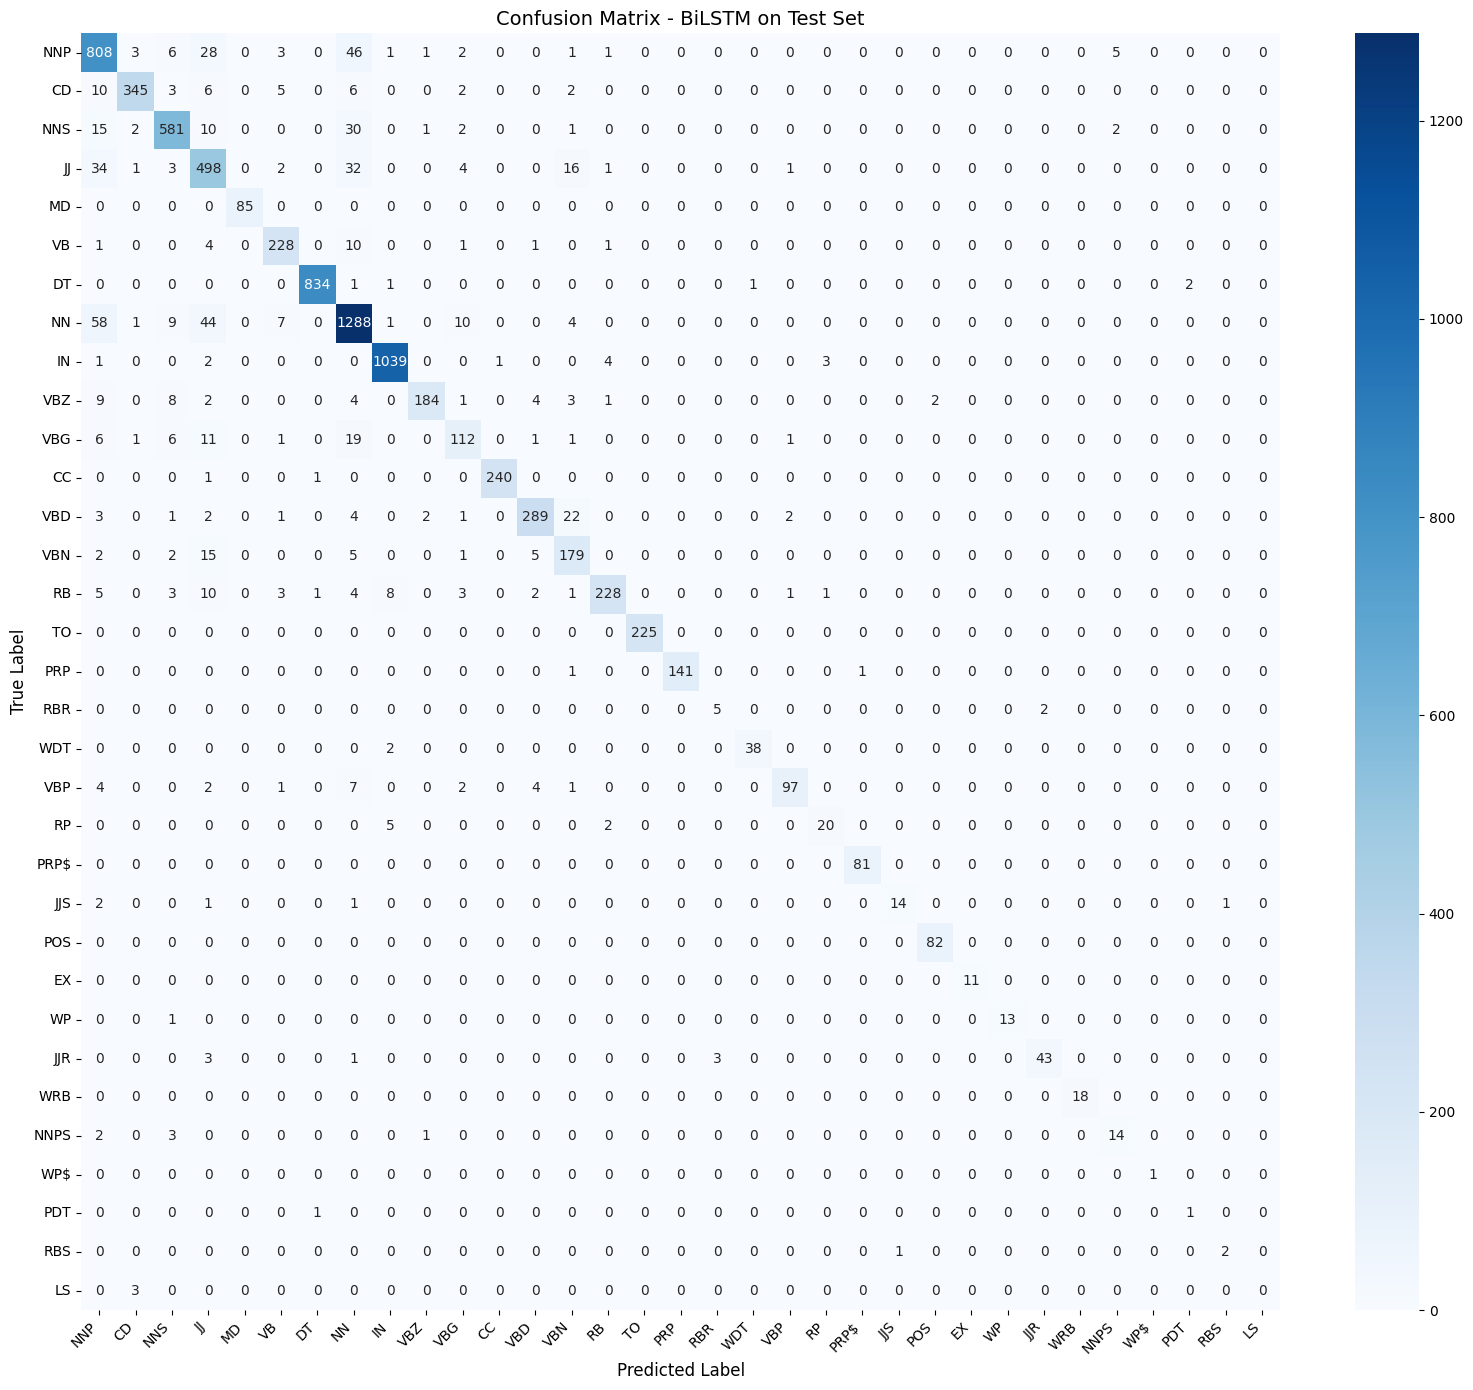

In [ ]:
# Get tag names
tag_names = [tag_vocab.idx2tag[i] for i in range(1, len(tag_vocab))]
unique_labels = sorted(set(test_labels))
label_names = [tag_vocab.idx2tag[i] for i in unique_labels]

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions, labels=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 14))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - {best_model_name} on Test Set', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

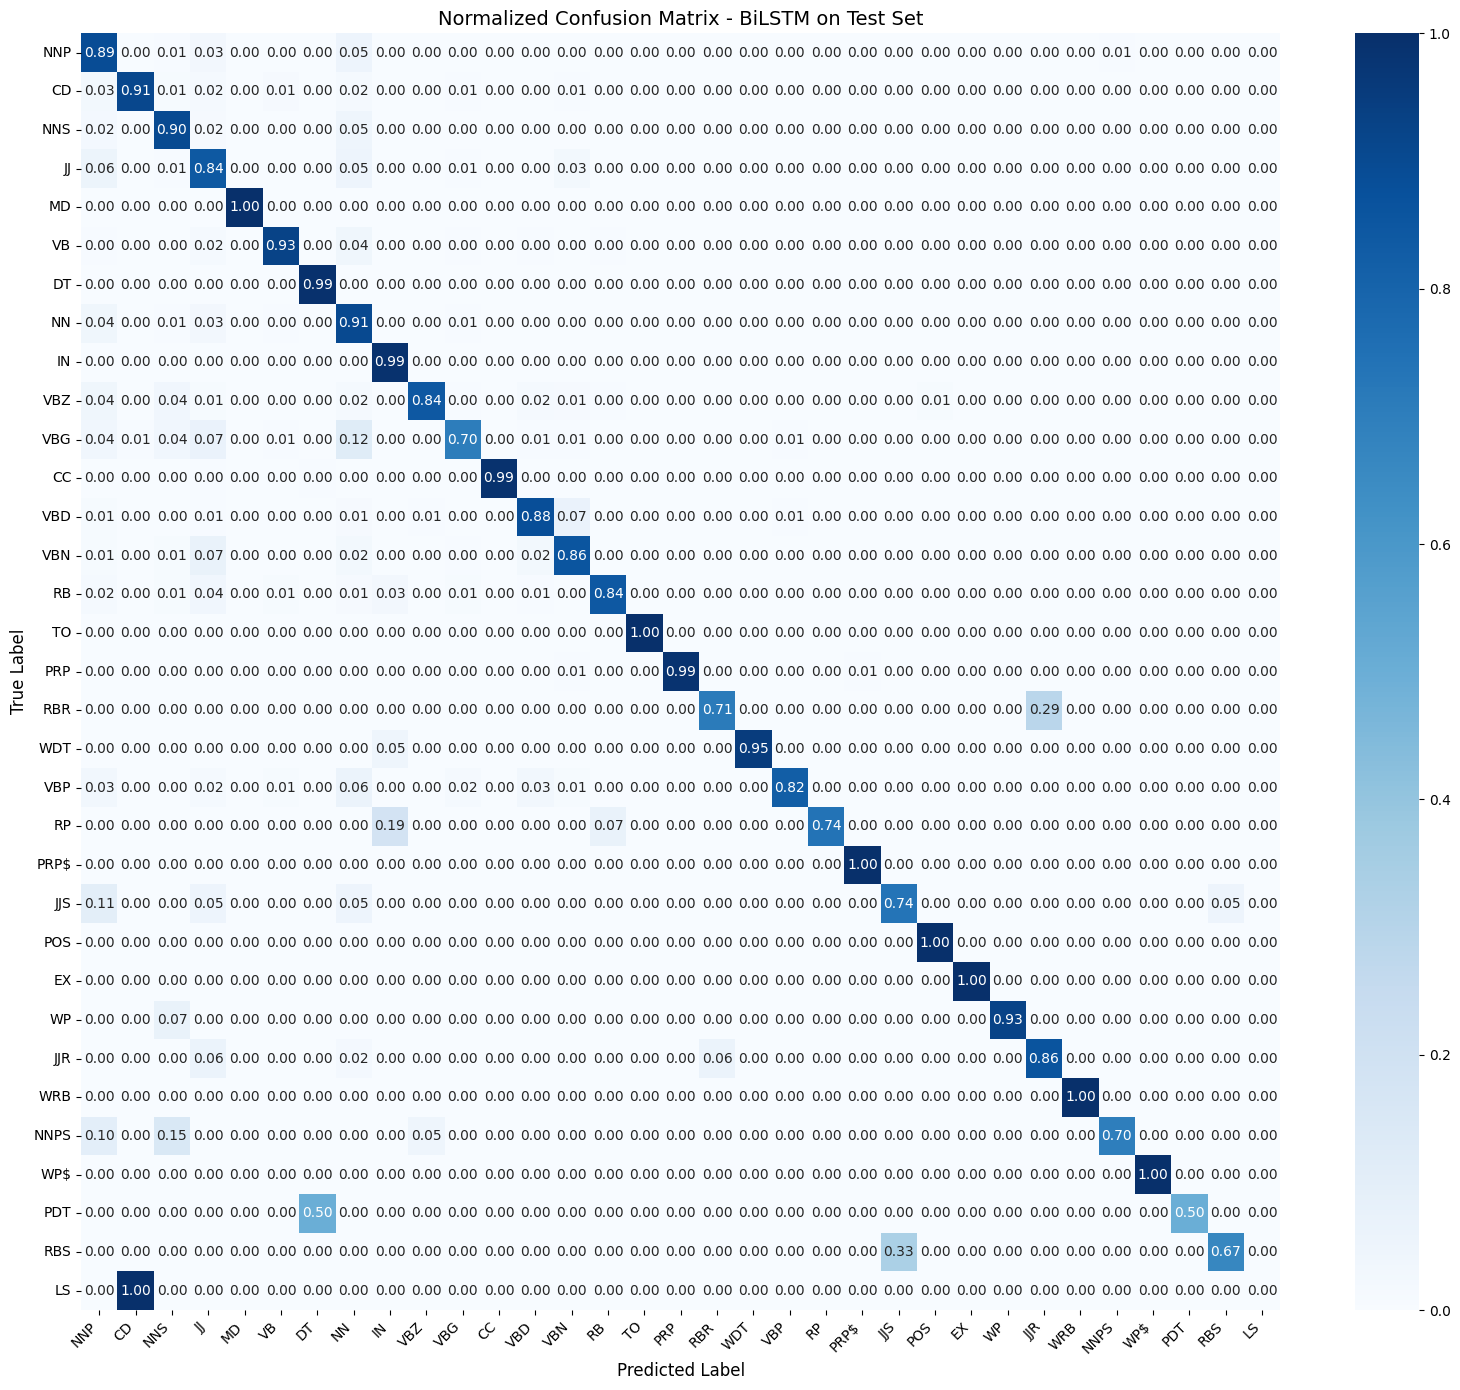

In [ ]:
# Normalised confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)

# Plot normalised confusion matrix
plt.figure(figsize=(16, 14))

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_names, yticklabels=label_names)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Normalized Confusion Matrix - {best_model_name} on Test Set', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()